In [2]:
%matplotlib inline
#%matplotlib notebook

In [3]:
import cytoflow as flow
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib
matplotlib.rc('figure', dpi = 160)

# Import samples and specify experimental condtions

In [4]:
inputs = [
    ["Experiment_Tube_001_001.fcs",1e-6,0],
    ["Experiment_Tube_002_002.fcs",1e-7, 0],
    ["Experiment_Tube_003_003.fcs",1e-8, 0],
    ["Experiment_Tube_004_004.fcs",1e-9, 0],
    ["Experiment_Tube_005_005.fcs",1e-10, 0],
    ["Experiment_Tube_006_006.fcs",1e-11, 0],
    ["Experiment_Tube_007_007.fcs",1e-12,0],
    ["Experiment_Tube_008_008.fcs",1e-6,2e-4],
    ["Experiment_Tube_009_009.fcs",1e-7, 2e-4],
    ["Experiment_Tube_010_010.fcs",1e-8, 2e-4],
    ["Experiment_Tube_011_011.fcs",1e-9, 2e-4],
    ["Experiment_Tube_012_012.fcs",1e-10, 2e-4],
    ["Experiment_Tube_013_013.fcs",1e-11, 2e-4],
    ["Experiment_Tube_014_014.fcs",1e-12,2e-4],
    ["Experiment_Tube_015_015.fcs",1e-6,1e-3],
    ["Experiment_Tube_016_016.fcs",1e-7, 1e-3],
    ["Experiment_Tube_017_017.fcs",1e-8, 1e-3],
    ["Experiment_Tube_018_018.fcs",1e-9, 1e-3],
    ["Experiment_Tube_019_019.fcs",1e-10, 1e-3],
    ["Experiment_Tube_020_020.fcs",1e-11, 1e-3],
    ["Experiment_Tube_021_021.fcs",1e-12,1e-3]
]

       
tubes = []
for filename, ahl, iptg in inputs:
    tubes.append(flow.Tube(file = 'data/' + filename, conditions = {'AHL' : ahl, 'IPTG' : iptg}))
    
ex = flow.ImportOp(conditions = {'AHL' : 'float', 'IPTG' : 'float'},
                   tubes = tubes).apply()
       


## Effect of fixation time on mNG intensity

# Plot FITC-A histograms for all IPTG and AHL induction conditions

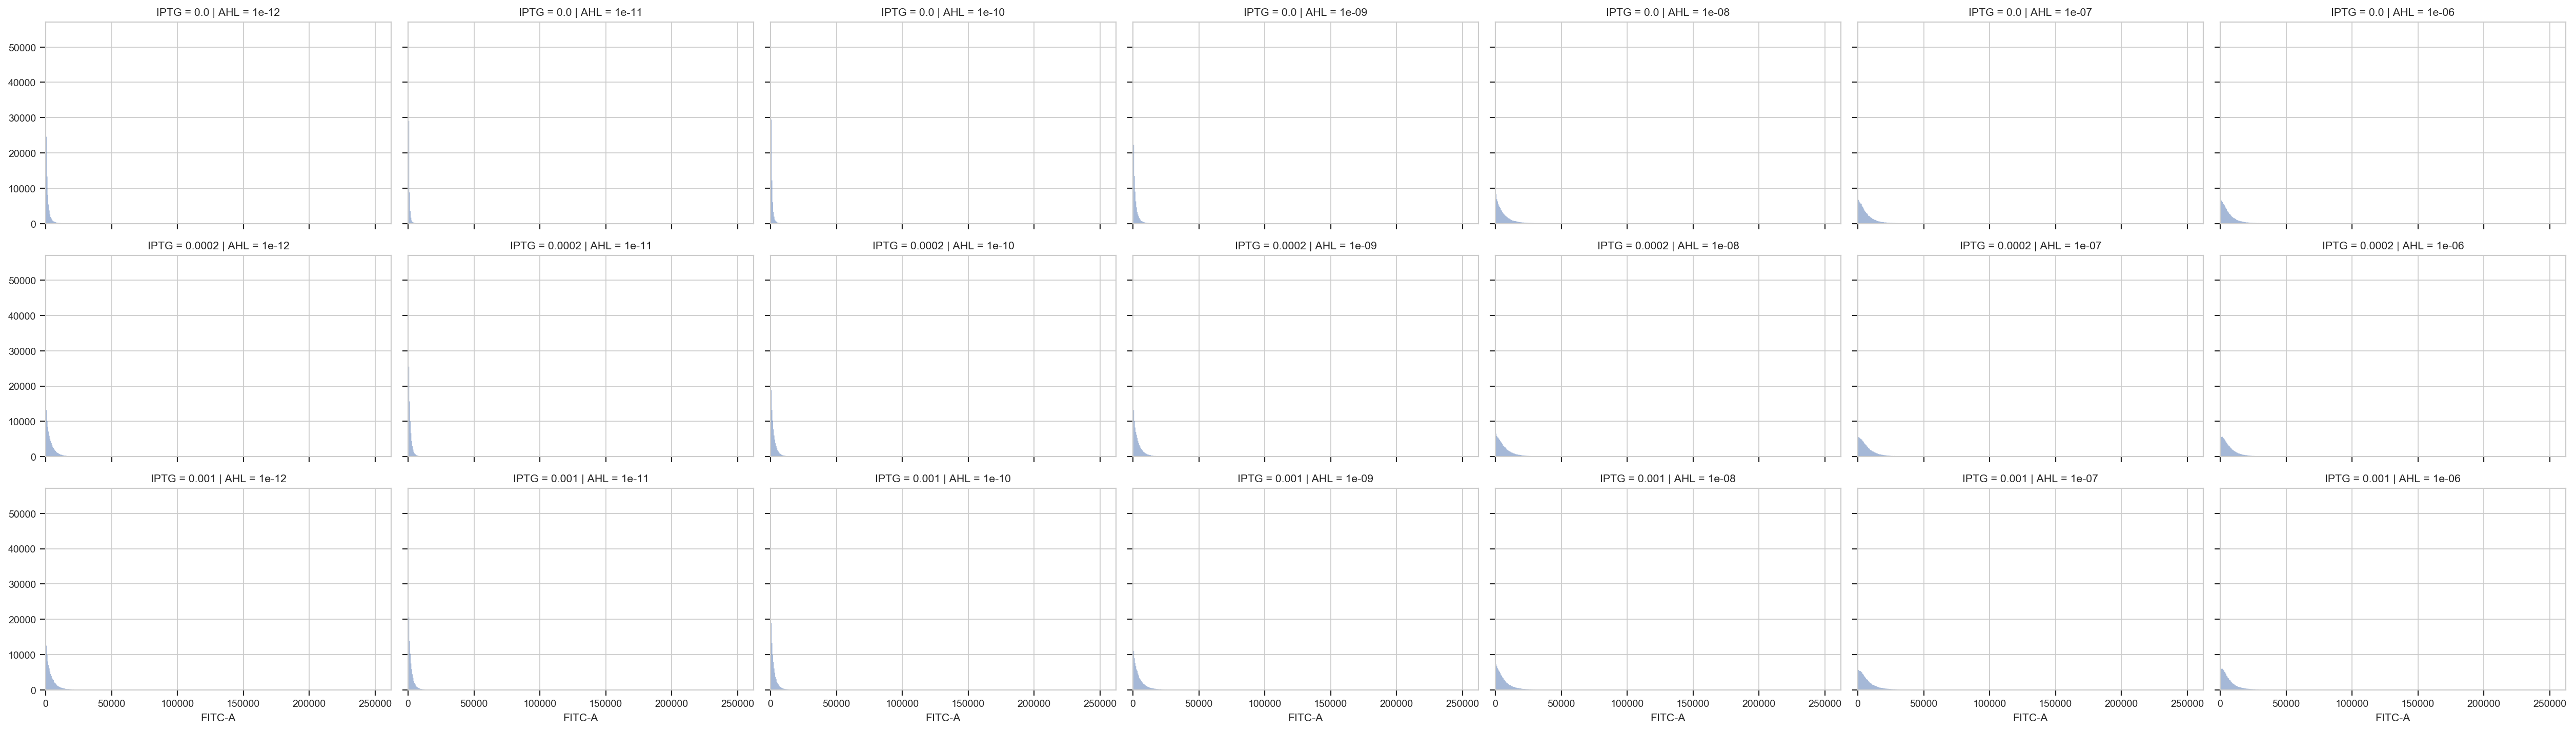

In [5]:

flow.HistogramView(channel = "FITC-A",
                   xfacet = "AHL",
                  yfacet = 'IPTG').plot(ex)

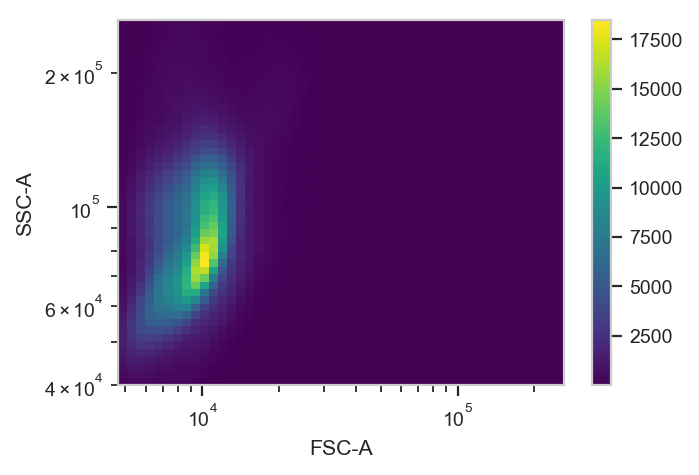

In [6]:
flow.DensityView(xchannel = "FSC-A", 
                 ychannel = "SSC-A",
                 xscale = 'log',
                 yscale = 'log').plot(ex, min_quantile = 0.005)

# Singlet gating to remove doublets

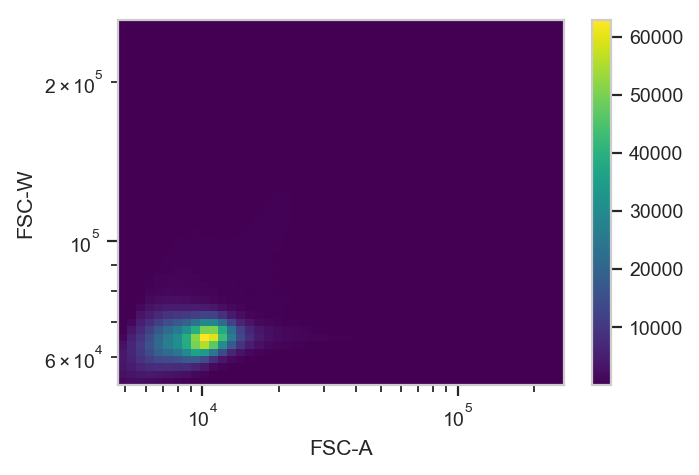

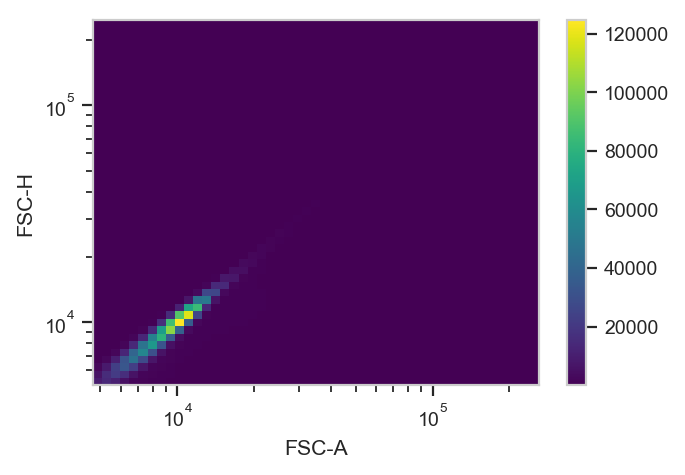

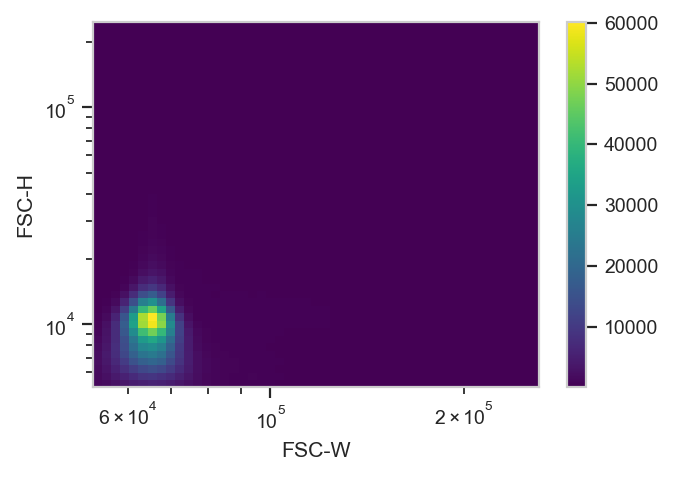

In [7]:

#channels = ['FSC-A','FSC-W','FSC-H','SSC-A','SSC-W','SSC-H']
#perm = combinations(channels,2)
FSC = [('FSC-A','FSC-W'),('FSC-A','FSC-H'),('FSC-W','FSC-H')]

#f, axes = plt.subplots(ncols=4,nrows=4)
#axs = axes.ravel()
for i,(x,y) in enumerate(FSC):  
    flow.DensityView(xchannel = x, 
                ychannel = y,
                xscale = 'log',
                yscale = 'log').plot(ex, min_quantile = 0.005)


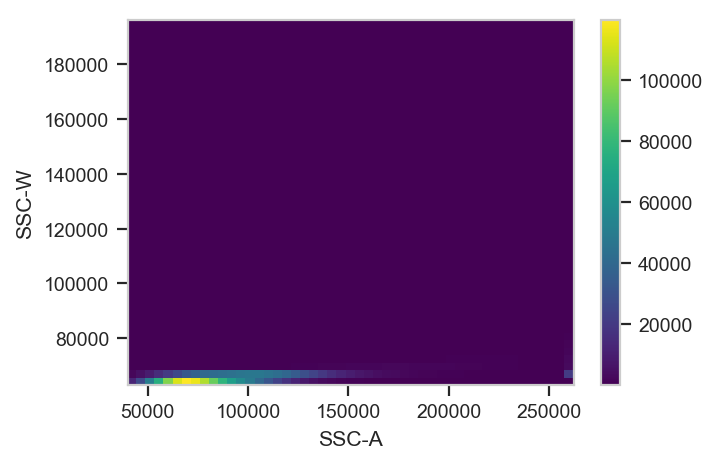

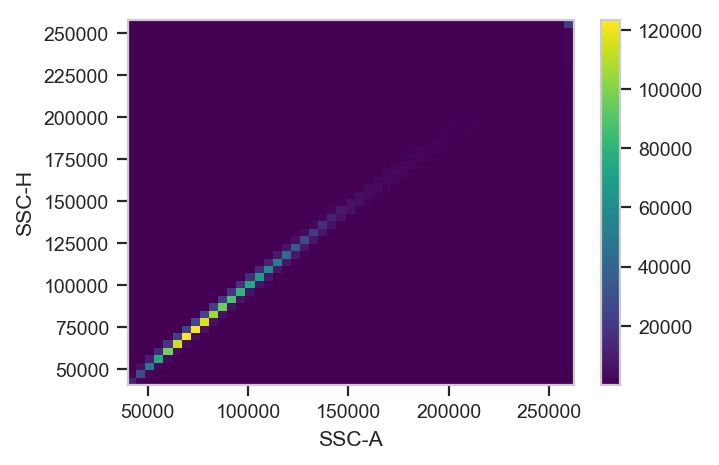

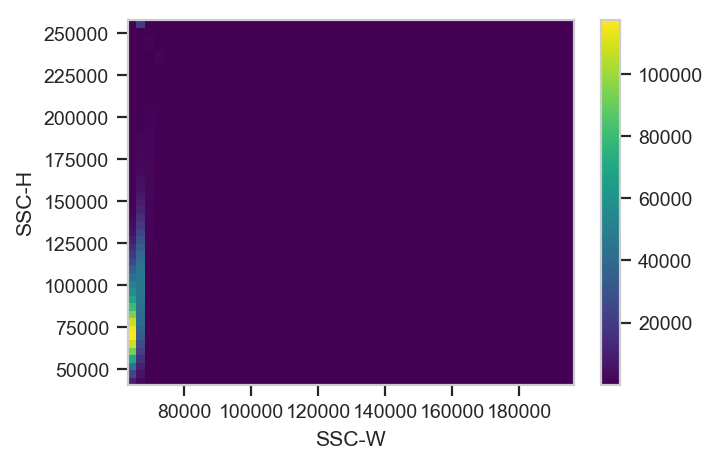

In [8]:
SSC = [('SSC-A','SSC-W'),('SSC-A','SSC-H'),('SSC-W','SSC-H')]
for i,(x,y) in enumerate(SSC):  
    flow.DensityView(xchannel = x, 
                ychannel = y,
                xscale = 'linear',
                yscale = 'linear').plot(ex, min_quantile = 0.005)

## Create and store singlet gate

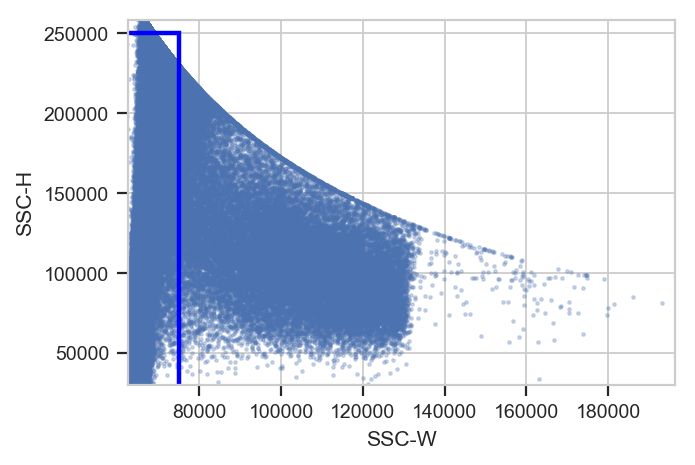

In [9]:
r = flow.Range2DOp(name = "Range2D",
                   xchannel = "SSC-W",
                   xlow = 55000,
                   xhigh = 75000,
                   ychannel = "SSC-H",
                   ylow = 5000,
                   yhigh = 250000)
                   
rv = r.default_view(xscale ='linear',yscale='linear')

rv.plot(ex)
ex2 = r.apply(ex)

## Use a gaussian mixture model to further gate the population

C:\Users\Jonathan\anaconda3\envs\cytoflow\lib\site-packages\cytoflow\operations\base_op_views.py:342: CytoflowViewWarning: Setting 'huefacet' to 'GM_1'


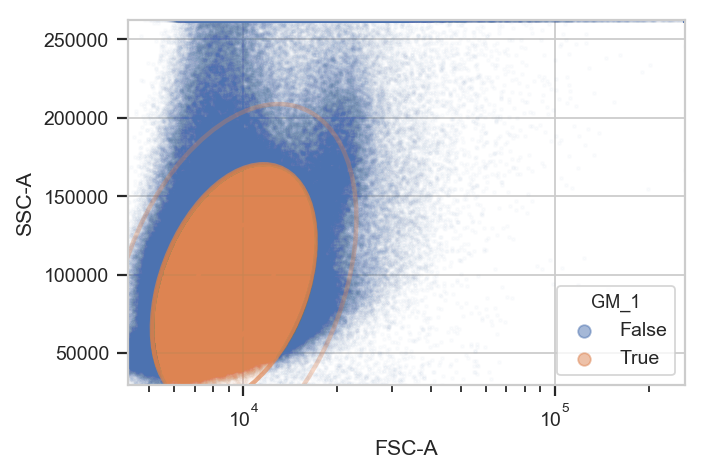

In [10]:
gm = flow.GaussianMixtureOp(name = "GM",
                            channels = ['FSC-A', 'SSC-A'],
                            scale = {'FSC-A' : 'log',
                                     'SSC-A' : 'linear'},
                            num_components = 1,
                            sigma = 2)
gm.estimate(ex2)
ex_gm = gm.apply(ex2)
gm.default_view().plot(ex_gm, alpha = 0.02)

C:\Users\Jonathan\anaconda3\envs\cytoflow\lib\site-packages\cytoflow\utility\log_scale.py:117: RuntimeWarning: invalid value encountered in log10
C:\Users\Jonathan\anaconda3\envs\cytoflow\lib\site-packages\cytoflow\utility\log_scale.py:117: RuntimeWarning: invalid value encountered in log10
C:\Users\Jonathan\anaconda3\envs\cytoflow\lib\site-packages\cytoflow\operations\gaussian.py:529: RuntimeWarning: invalid value encountered in less_equal
C:\Users\Jonathan\anaconda3\envs\cytoflow\lib\site-packages\cytoflow\operations\base_op_views.py:342: CytoflowViewWarning: Setting 'huefacet' to 'GM3_1'


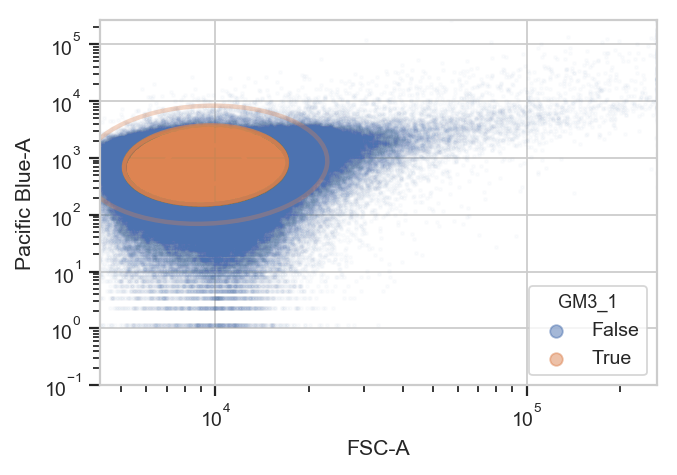

In [11]:
gm3 = flow.GaussianMixtureOp(name = "GM3",
                            channels = ['FSC-A', 'Pacific Blue-A'],
                            scale = {'FSC-A' : 'log',
                                     'Pacific Blue-A' : 'log'},
                            num_components = 1,
                            sigma = 2)
gm3.estimate(ex_gm)
ex_gm2 = gm3.apply(ex_gm)
gm3.default_view().plot(ex_gm2, alpha = 0.02)

In [12]:
df =ex_gm2.data

# filter out events that don't fall within the gates

In [13]:

df = df[(df.GM_1==True) & (df.GM3_1==True) & (df.Range2D==True) & (df['FITC-A'] >0)]
df

,AHL,FITC-A,FITC-H,FITC-W,FSC-A,FSC-H,FSC-W,IPTG,Pacific Blue-A,Pacific Blue-H,Pacific Blue-W,SSC-A,SSC-H,SSC-W,Time,Range2D,GM_1,GM3_1
0,1.000000e-06,3445.189941,3283.0,68773.671875,7459.939941,8119.0,60216.117188,0.000,1101.750000,770.0,93771.804688,78413.445312,78883.0,65145.894531,62.599998,True,True,True
1,1.000000e-06,6601.129883,6684.0,64723.464844,8330.179688,7864.0,69420.984375,0.000,449.739990,497.0,59304.144531,58702.617188,59432.0,64731.707031,62.599998,True,True,True
2,1.000000e-06,1977.579956,2118.0,61191.066406,7760.379883,8146.0,62433.617188,0.000,1196.670044,1143.0,68613.273438,117160.484375,117174.0,65528.441406,62.599998,True,True,True
3,1.000000e-06,404.949982,343.0,77372.601562,13127.600586,12659.0,67961.960938,0.000,2046.429932,1828.0,73366.976562,112132.875000,112035.0,65593.257812,62.599998,True,True,True
4,1.000000e-06,9773.089844,9767.0,65576.867188,10398.480469,11198.0,60856.835938,0.000,872.359985,984.0,58100.593750,109085.515625,108452.0,65918.820312,62.599998,True,True,True
5,1.000000e-06,28679.359375,29013.0,64782.359375,7125.459961,7617.0,61306.832031,0.000,1481.430054,1414.0,68661.250000,92071.390625,92133.0,65492.171875,62.700001,True,True,True
6,1.000000e-06,5582.969727,5445.0,67196.609375,9079.060547,9729.0,61157.914062,0.000,759.359985,404.0,123181.718750,78631.500000,80097.0,64336.921875,62.700001,True,True,True
7,1.000000e-06,10691.570312,10616.0,66002.515625,5647.680176,6204.0,59659.308594,0.000,1174.069946,1321.0,58246.667969,89623.890625,89048.0,65959.843750,62.700001,True,True,True
8,1.000000e-06,4757.939941,5004.0,62313.417969,10050.679688,10568.0,62327.910156,0.000,325.440002,657.0,32462.763672,84082.750000,83448.0,66034.507812,62.700001,True,True,True
10,1.000000e-06,16476.570312,16789.0,64316.425781,7719.680176,8577.0,58985.308594,0.000,842.979980,908.0,60843.101562,70535.171875,70533.0,65538.015625,62.700001,True,True,True


In [14]:
import scipy.stats as stats
import scipy as sp
from scipy.stats.mstats import gmean
import numpy as np

def geom_sd(a):
    a = np.array(a)
    u = gmean(a)
    a[a <= 0] = np.abs(a[a <= 0]) + 2 * u
    
    return np.exp(np.std(np.log(a)))
def geom_sem(a):
    a = np.array(a)
    u = geom_mean(a)
    a[a <= 0] = np.abs(a[a <= 0]) + 2 * u
def geom_std(values):
    """
    Calculates the geometric standard deviation for the passed values.
    Source: https://en.wikipedia.org/wiki/Geometric_standard_deviation
    """

   # gmean = stats.gmean(values)
    return sp.exp(sp.sqrt(sp.sum([sp.log(x / gmean(values)) ** 2 for x in values]) / len(values))) 


# Plot mean FITC-A

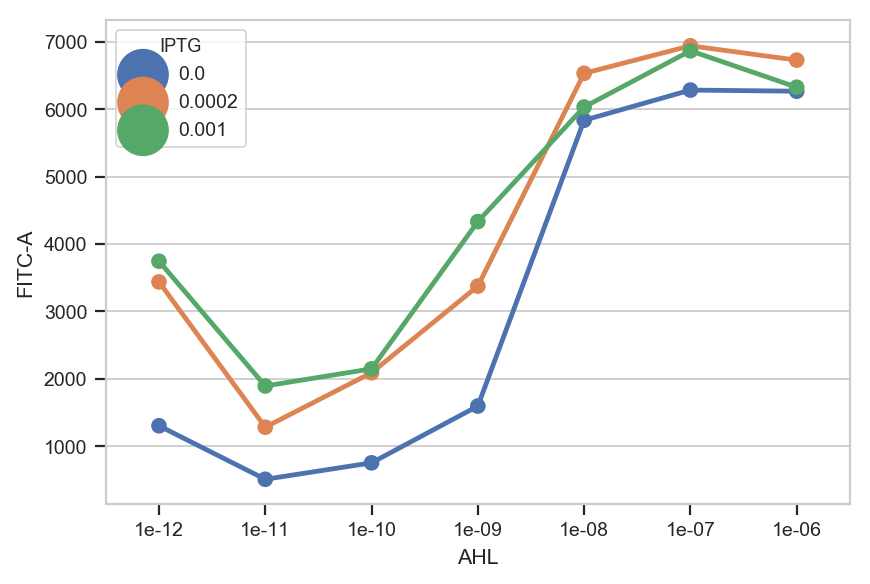

In [15]:
sns.pointplot(x='AHL',y='FITC-A',hue='IPTG',data=df)

In [16]:
gb = df.groupby(['AHL','IPTG'])
mean = df.groupby(['AHL','IPTG'])['FITC-A'].apply(gmean).reset_index()
geostd = df.groupby(['AHL','IPTG'])['FITC-A'].apply(geom_sd).reset_index()

std = df.groupby(['AHL','IPTG'])['FITC-A'].std().reset_index()


# Plot Geometric mean FITC-A

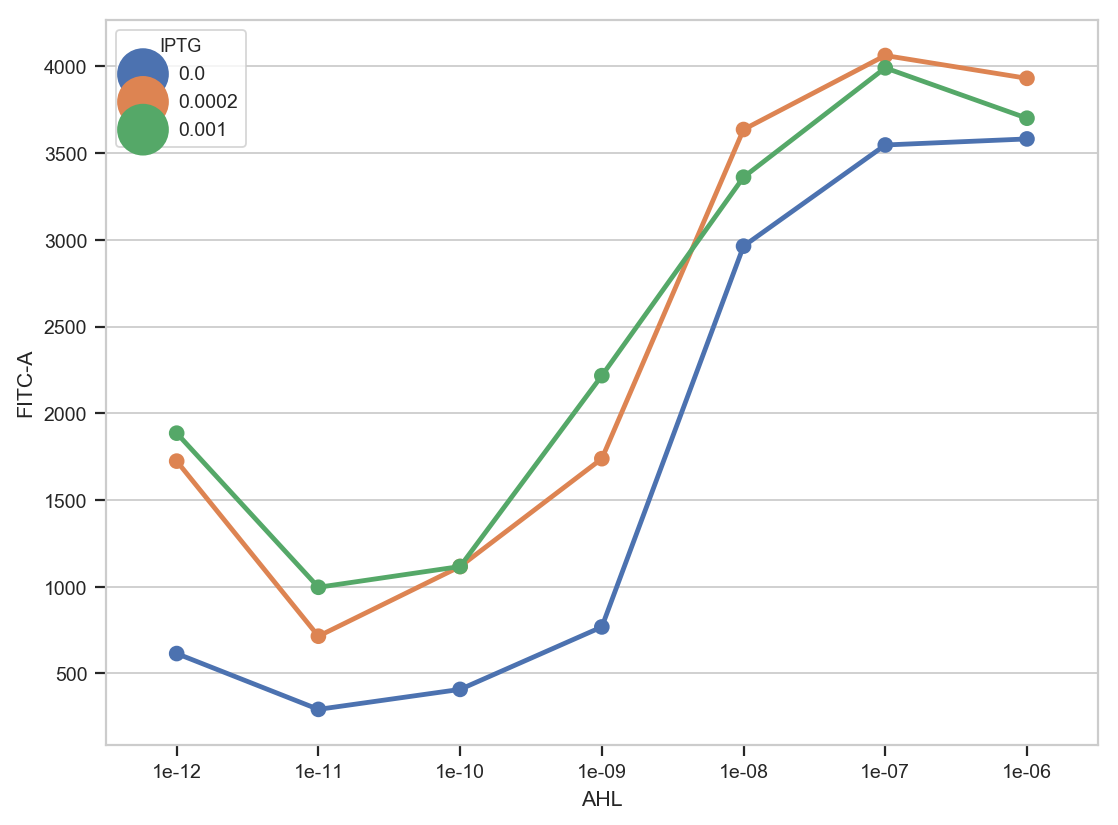

In [17]:
f, ax = plt.subplots(figsize=(8,6))
sns.pointplot(x='AHL',y='FITC-A',hue='IPTG',estimator=gmean,ci=0.01,data=df)
f.savefig('Lux.png',dpi=600)

In [18]:
mean

,AHL,IPTG,FITC-A
0,1.000000e-12,0.0000,614.785155
1,1.000000e-12,0.0002,1724.199948
2,1.000000e-12,0.0010,1885.392115
3,1.000000e-11,0.0000,292.961072
4,1.000000e-11,0.0002,714.778050
5,1.000000e-11,0.0010,996.877961
6,1.000000e-10,0.0000,408.220224
7,1.000000e-10,0.0002,1116.590448
8,1.000000e-10,0.0010,1116.677507
9,1.000000e-09,0.0000,768.224885


# Calculate standard deviation percentages

In [19]:
std['FITC-A']/mean['FITC-A']*100

0     308.772929
1     228.916396
2     228.586568
3     220.276563
4     204.157039
5     221.922891
6     233.700982
7     210.720113
8     226.207825
9     271.372674
10    212.488660
11    220.678399
12    219.868638
13    184.552854
14    188.063548
15    187.001729
16    167.418026
17    172.276109
18    187.978799
19    171.344651
20    175.561726
Name: FITC-A, dtype: float64

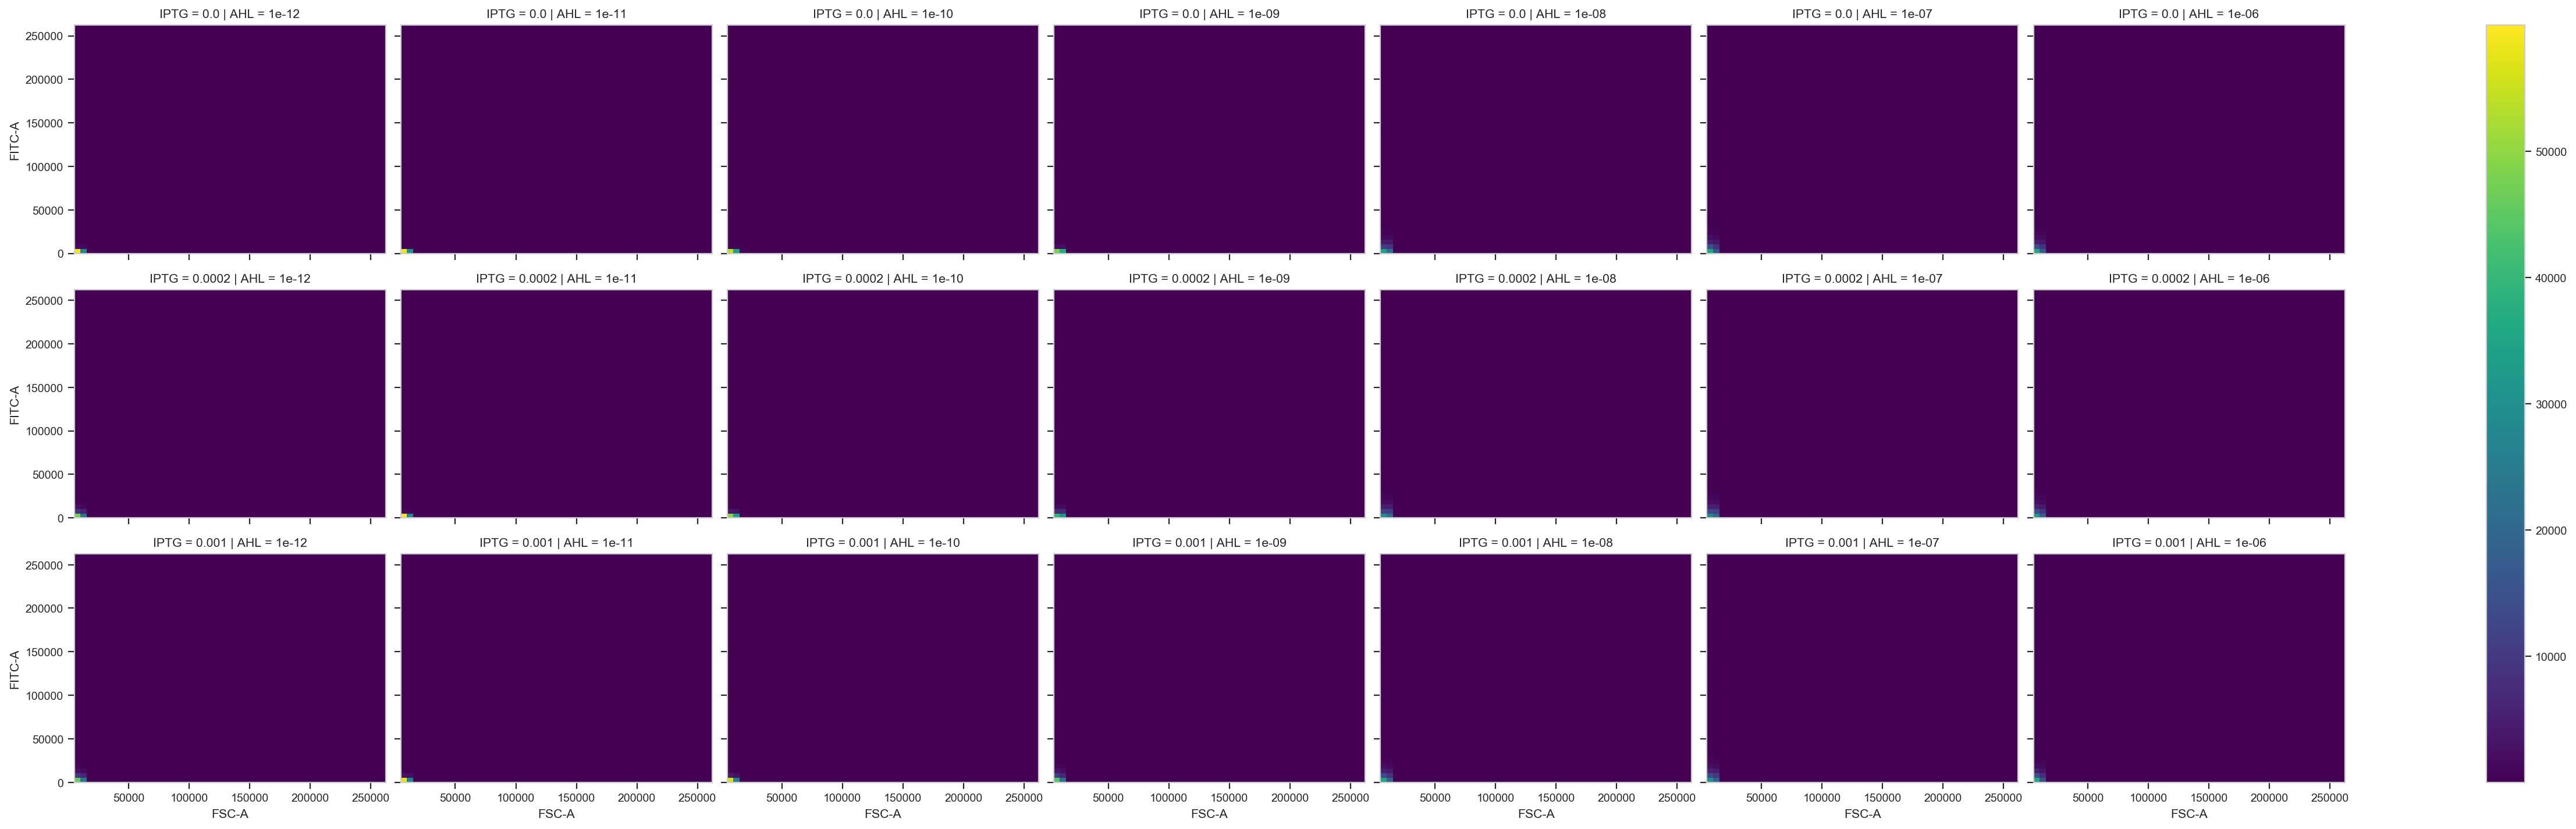

In [20]:

flow.DensityView(xchannel = 'FSC-A', 
                ychannel = 'FITC-A',
                   xfacet = "AHL",
                yfacet='IPTG',
                 subset = 'GM_1 == True').plot(ex_gm2, min_quantile = 0.01)

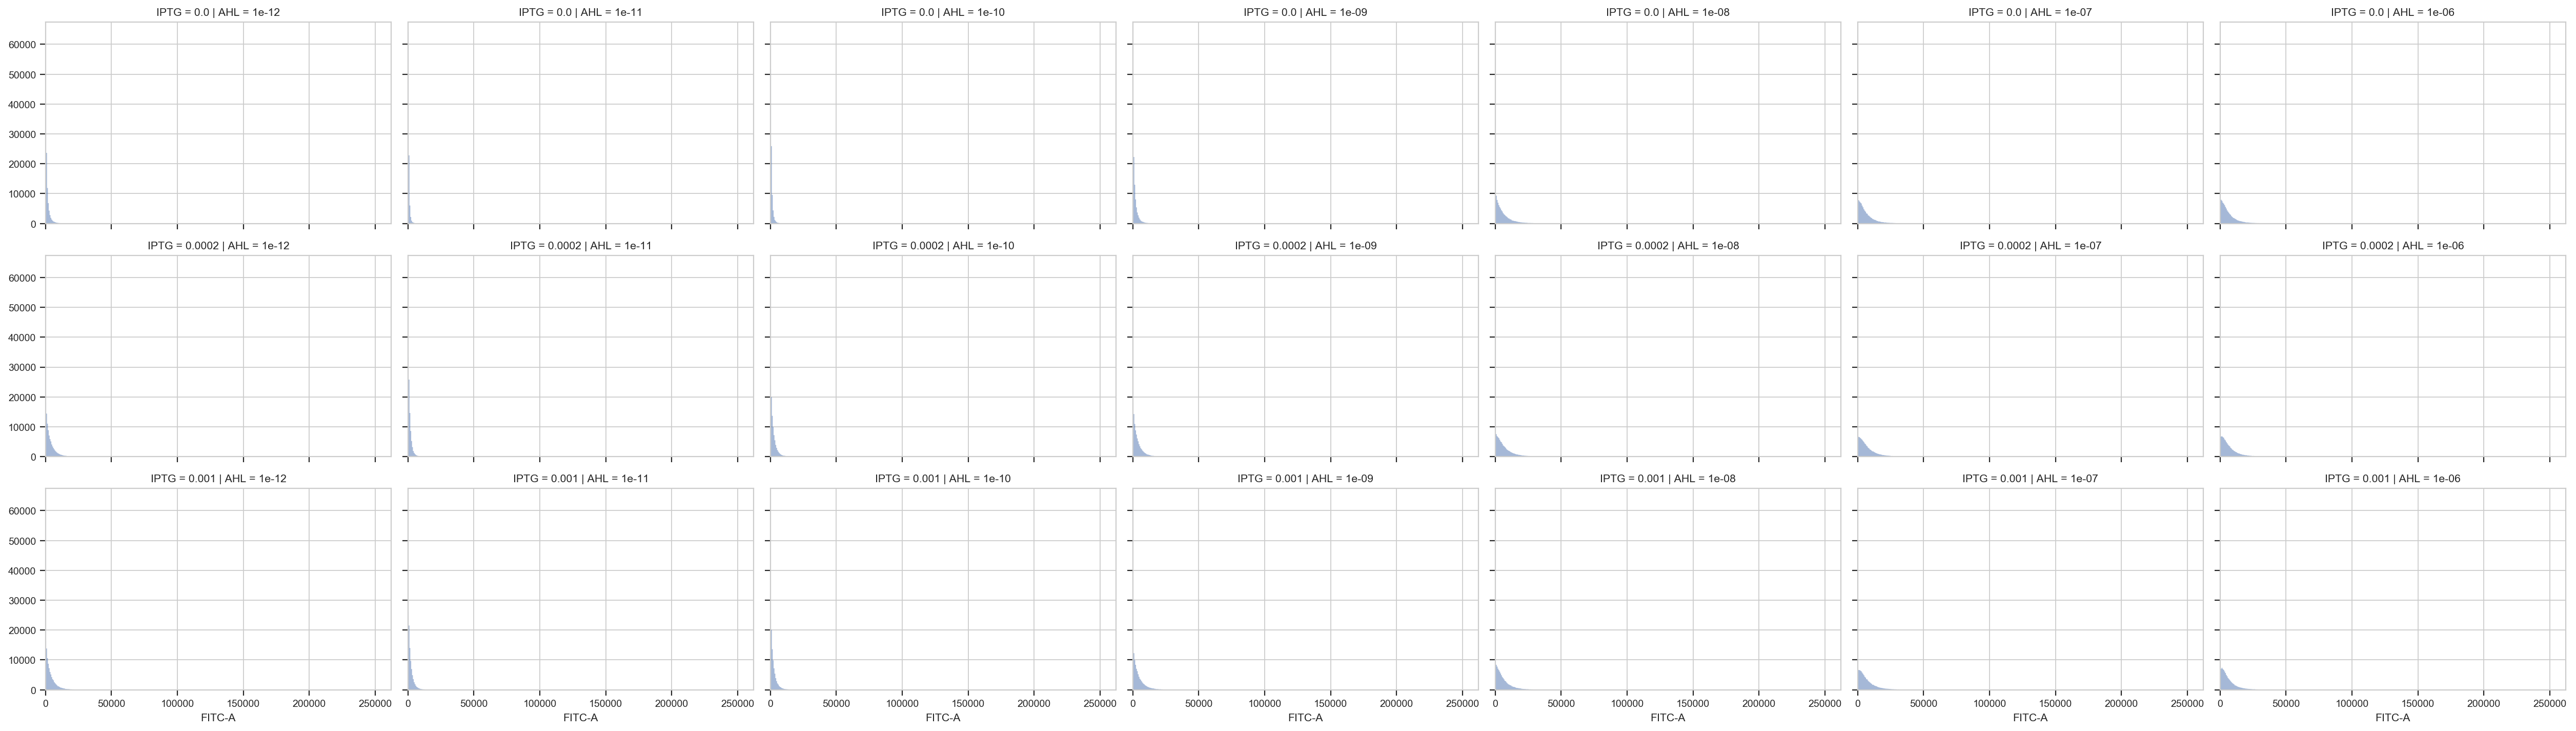

In [21]:
flow.HistogramView(channel = 'FITC-A',
                   xfacet = "AHL",
                yfacet='IPTG',
                 subset = 'Range2D == True').plot(ex_gm2, min_quantile = 0.01)

# Plot heatmaps showing absolute and relative induction

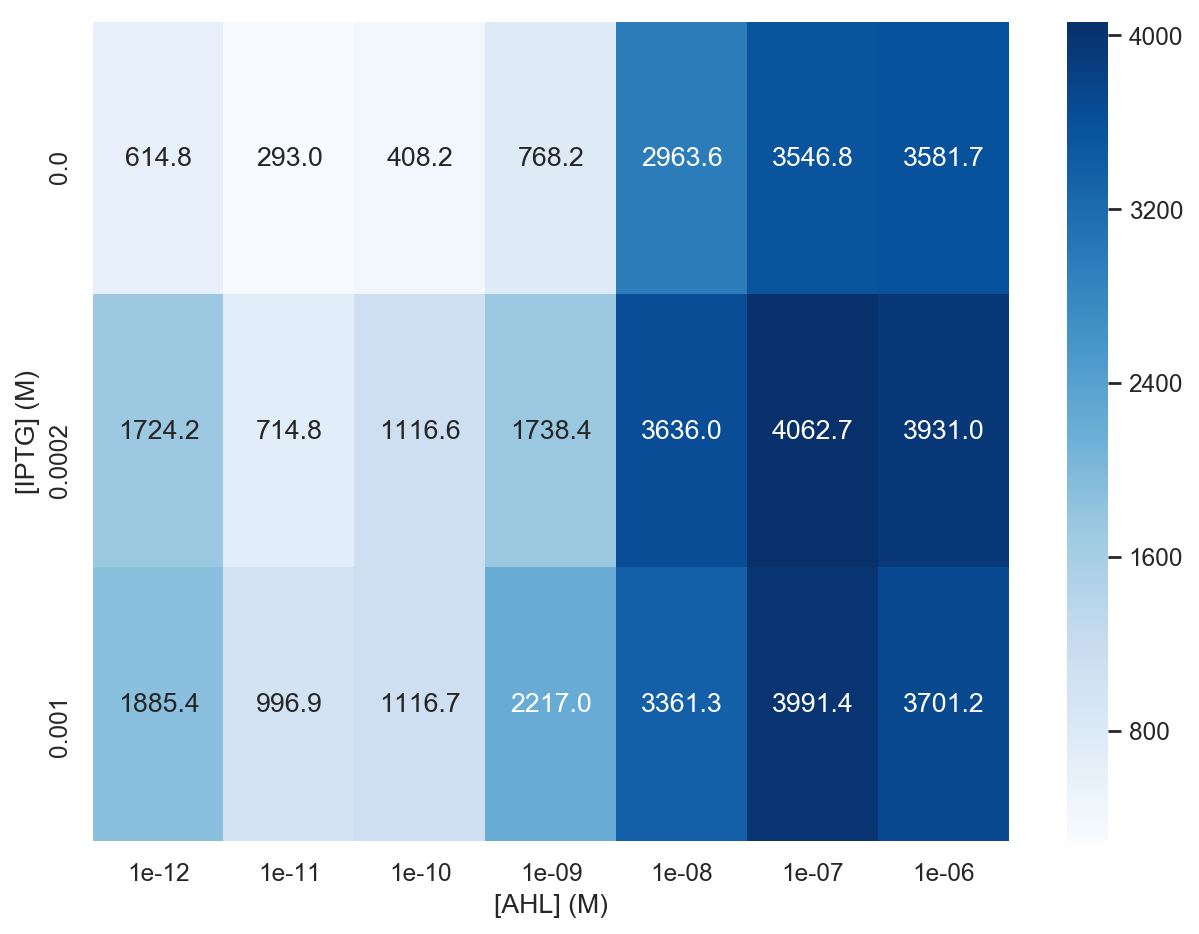

In [22]:
#LasMeans = Las.groupby(['C_ahl','C_iptg']).mean().reset_index()
sns.set(style="white")
#sns.set_style('Talk')
#LasTable = pd.pivot_table(LasMeans,values='FITC-A',index='C_iptg',columns='C_ahl')
f, ax = plt.subplots(figsize=(8,6))
#g = sns.heatmap(LasTable,vmin=0,vmax=100,xticklabels=[0,1e-10,1e-9,1e-7],yticklabels=[0,1e-3,1e-4,1e-5],ax=ax,square=True,cmap='Reds')



#f.savefig('LasHeatmap.png',dpi=600)
mean = df.groupby(['AHL','IPTG'])['FITC-A'].apply(gmean).reset_index()
#mean['FITC-A']=mean['FITC-A']/mean['FITC-A'].max()*100

piv = mean.pivot_table(index='IPTG', columns='AHL', values='FITC-A')
g = sns.heatmap(piv, annot=True, fmt=".1f",cmap='Blues')
cbar = g.collections[0].colorbar
#cbar.set_ticks([0, 25, 50, 75,100])
#cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
ax.set_xlabel(r'[AHL] (M)')
ax.set_ylabel(r'[IPTG] (M)')
f.tight_layout()

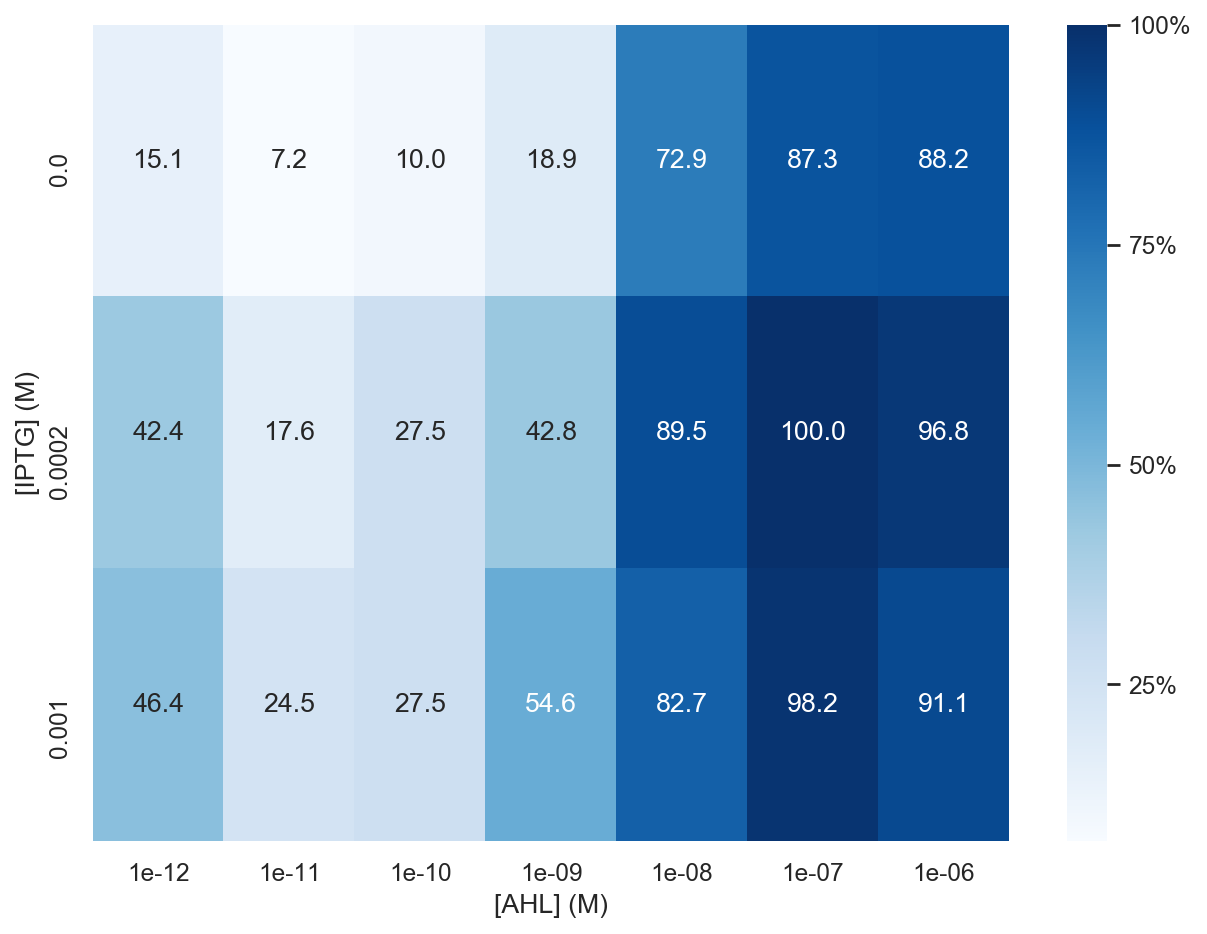

In [23]:
f, ax = plt.subplots(figsize=(8,6))
# normalized
mean['FITC-A']=mean['FITC-A']/mean['FITC-A'].max()*100

piv = mean.pivot_table(index='IPTG', columns='AHL', values='FITC-A')
g = sns.heatmap(piv, annot=True, fmt=".1f",cmap='Blues')
cbar = g.collections[0].colorbar
cbar.set_ticks([0, 25, 50, 75,100])
cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
ax.set_xlabel(r'[AHL] (M)')
ax.set_ylabel(r'[IPTG] (M)')
f.tight_layout()

# Calculate the on/off ratio and plot

In [24]:

R =[]
for i in mean.IPTG.unique():
    tmp = mean[mean.IPTG ==i]['FITC-A'].max()/mean[mean.IPTG ==i]['FITC-A'].min()
    R.append([i,tmp])



In [25]:

R = pd.DataFrame(R,columns=['IPTG','Induction Ratio'])
R

,IPTG,Induction Ratio
0,0.0000,12.225968
1,0.0002,5.683840
2,0.0010,4.003944


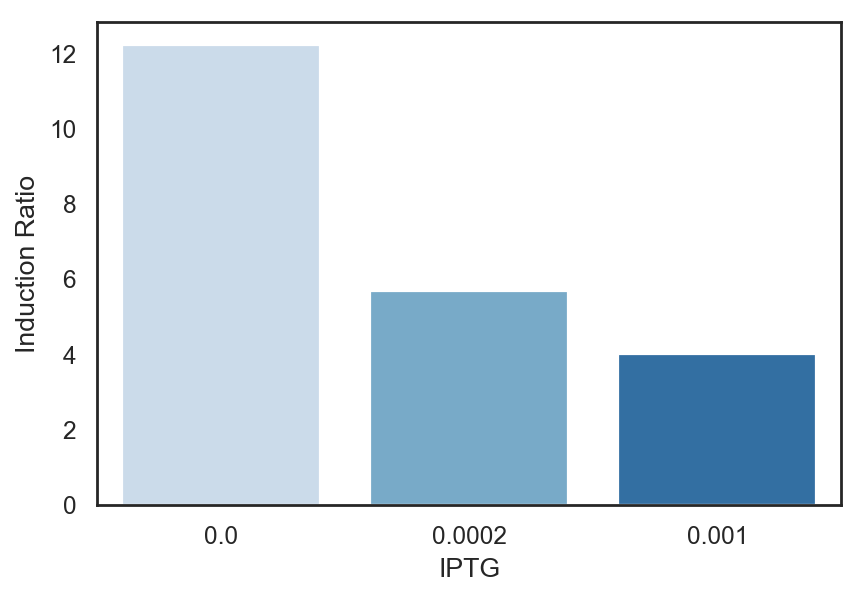

In [26]:
f, ax  = plt.subplots()
sns.barplot(x='IPTG',y='Induction Ratio',data=R,palette='Blues')

# Fit data to logistic function

In [27]:
import scipy.optimize as opt
mean = df.groupby(['AHL','IPTG'])['FITC-A'].apply(gmean).reset_index()
data = mean.copy()
data.AHL[data.AHL == 0]=1e-14


In [28]:
data

,AHL,IPTG,FITC-A
0,1.000000e-12,0.0000,614.785155
1,1.000000e-12,0.0002,1724.199948
2,1.000000e-12,0.0010,1885.392115
3,1.000000e-11,0.0000,292.961072
4,1.000000e-11,0.0002,714.778050
5,1.000000e-11,0.0010,996.877961
6,1.000000e-10,0.0000,408.220224
7,1.000000e-10,0.0002,1116.590448
8,1.000000e-10,0.0010,1116.677507
9,1.000000e-09,0.0000,768.224885


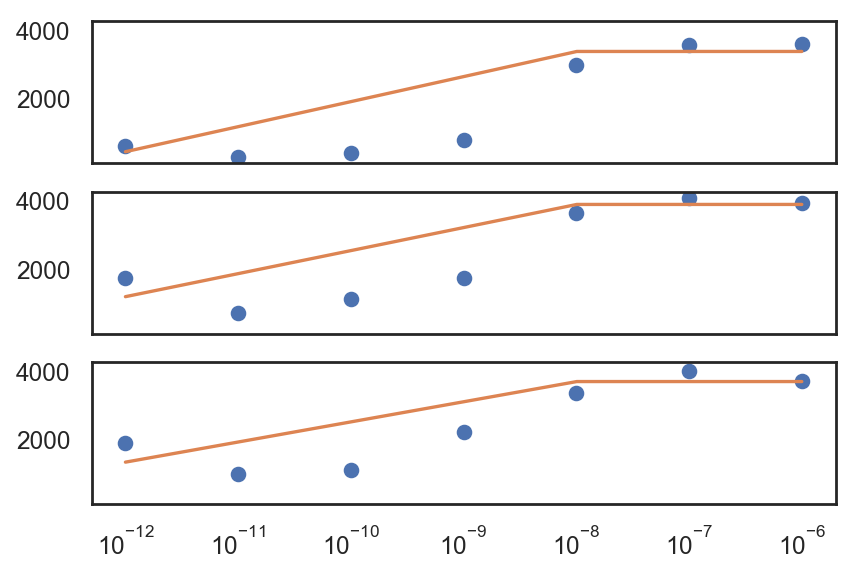

In [29]:
def f(x, a, b, c, d):
    return (a -b) / (1 + np.exp(c * (np.log10(d)-np.log10(x)))) + b
fig, axes = plt.subplots(3, 1, figsize=(6, 4),sharex=True,sharey=True)
axs = axes.ravel()
for i,iptg in enumerate(data.IPTG.unique()):
    tmp = data[data.IPTG==iptg]
    (a_, b_, c_, d_), _ = opt.curve_fit(f, tmp.AHL, tmp['FITC-A'],p0=[5e3,1e2,1e2,1e-9],maxfev=10000000)
    n = 100
    x = np.linspace(tmp.AHL.min(), tmp.AHL.max(), n)

    y_fit = f(x, a_, b_, c_, d_)

    
    axs[i].plot(tmp.AHL.values, tmp['FITC-A'].values, 'o')
    axs[i].plot(x, y_fit, '-')
    plt.xscale('log')
plt.show()

In [30]:
tmp.AHL

2     1.000000e-12
5     1.000000e-11
8     1.000000e-10
11    1.000000e-09
14    1.000000e-08
17    1.000000e-07
20    1.000000e-06
Name: AHL, dtype: float64

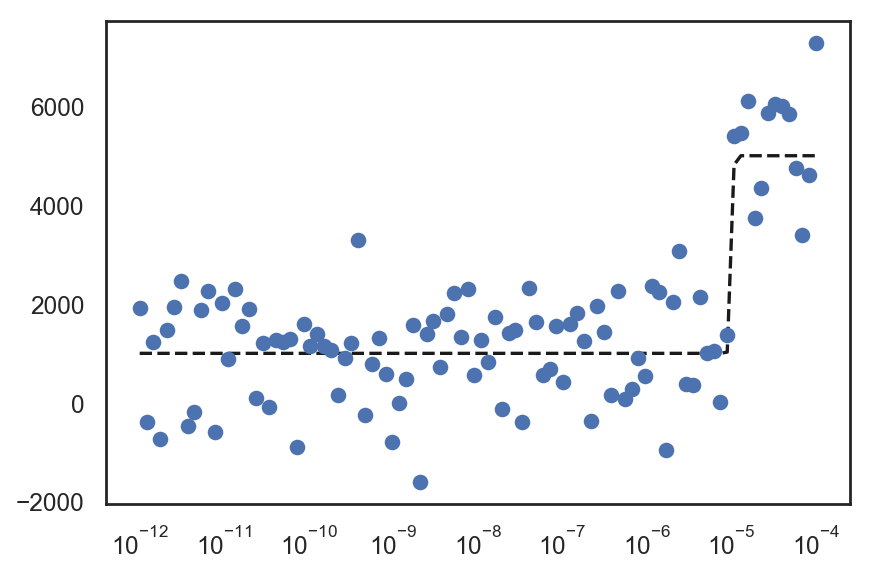

In [31]:
#a, c = np.random.exponential(size=2,scale=1e4)
#b, d = np.random.randn(2)
a,b,c,d = 5000,1000,1e2,1e-5
n = 100
#x = np.linspace(-12, -4, n)
x = np.logspace(-12,-4,n)
y_model = f(x, a, b, c, d)
y = y_model + a * .2 * np.random.randn(n)
#(a_, b_, c_, d_), _ = opt.curve_fit(f, x, y,p0=[1e4,1,1,d])
#y_fit = f(x, a_, b_, c_, d_)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(x, y_model, '--k')
ax.plot(x, y, 'o')
#ax.plot(x, y_fit, '-')
plt.xscale('log')



In [32]:
print(a_, b_, c_, d_)

3684.6570371497546 1332.982527712558 100.0 1.0117426706357768e-09


In [33]:
np.log10(0)

C:\Users\Jonathan\anaconda3\envs\cytoflow\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10


-inf

In [34]:
x

array([1.00000000e-12, 1.20450354e-12, 1.45082878e-12, 1.74752840e-12,
       2.10490414e-12, 2.53536449e-12, 3.05385551e-12, 3.67837977e-12,
       4.43062146e-12, 5.33669923e-12, 6.42807312e-12, 7.74263683e-12,
       9.32603347e-12, 1.12332403e-11, 1.35304777e-11, 1.62975083e-11,
       1.96304065e-11, 2.36448941e-11, 2.84803587e-11, 3.43046929e-11,
       4.13201240e-11, 4.97702356e-11, 5.99484250e-11, 7.22080902e-11,
       8.69749003e-11, 1.04761575e-10, 1.26185688e-10, 1.51991108e-10,
       1.83073828e-10, 2.20513074e-10, 2.65608778e-10, 3.19926714e-10,
       3.85352859e-10, 4.64158883e-10, 5.59081018e-10, 6.73415066e-10,
       8.11130831e-10, 9.77009957e-10, 1.17681195e-09, 1.41747416e-09,
       1.70735265e-09, 2.05651231e-09, 2.47707636e-09, 2.98364724e-09,
       3.59381366e-09, 4.32876128e-09, 5.21400829e-09, 6.28029144e-09,
       7.56463328e-09, 9.11162756e-09, 1.09749877e-08, 1.32194115e-08,
       1.59228279e-08, 1.91791026e-08, 2.31012970e-08, 2.78255940e-08,
      

In [35]:
data


,AHL,IPTG,FITC-A
0,1.000000e-12,0.0000,614.785155
1,1.000000e-12,0.0002,1724.199948
2,1.000000e-12,0.0010,1885.392115
3,1.000000e-11,0.0000,292.961072
4,1.000000e-11,0.0002,714.778050
5,1.000000e-11,0.0010,996.877961
6,1.000000e-10,0.0000,408.220224
7,1.000000e-10,0.0002,1116.590448
8,1.000000e-10,0.0010,1116.677507
9,1.000000e-09,0.0000,768.224885


In [36]:
df.AHL.unique()

array([1.e-06, 1.e-07, 1.e-08, 1.e-09, 1.e-10, 1.e-11, 1.e-12])

In [37]:
df[df.AHL==1e-4]['FITC-A']

Series([], Name: FITC-A, dtype: float64)

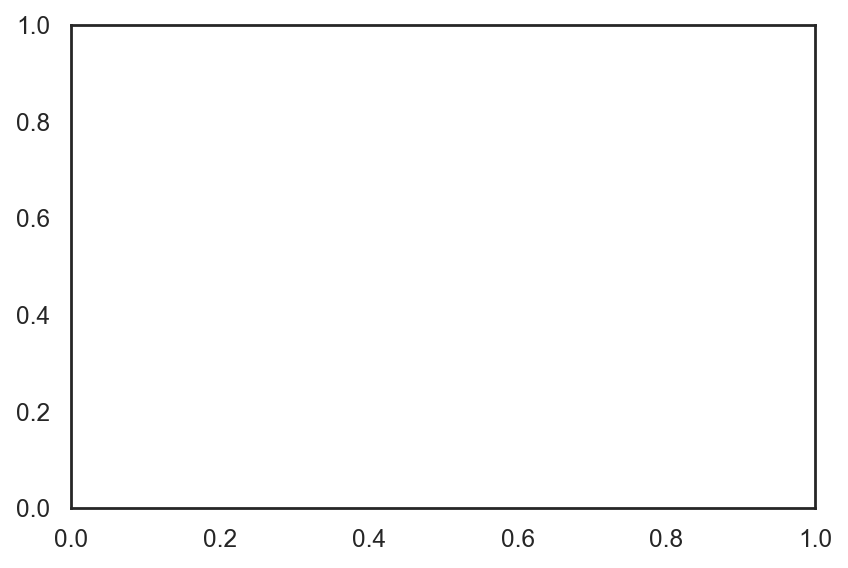

In [38]:
sns.kdeplot(df[df.AHL==1e-4]['FITC-A'])

C:\Users\Jonathan\anaconda3\envs\cytoflow\lib\site-packages\matplotlib\tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
C:\Users\Jonathan\anaconda3\envs\cytoflow\lib\site-packages\matplotlib\tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
C:\Users\Jonathan\anaconda3\envs\cytoflow\lib\site-packages\matplotlib\tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
C:\Users\Jonathan\anaconda3\envs\cytoflow\lib\site-packages\matplotlib\tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


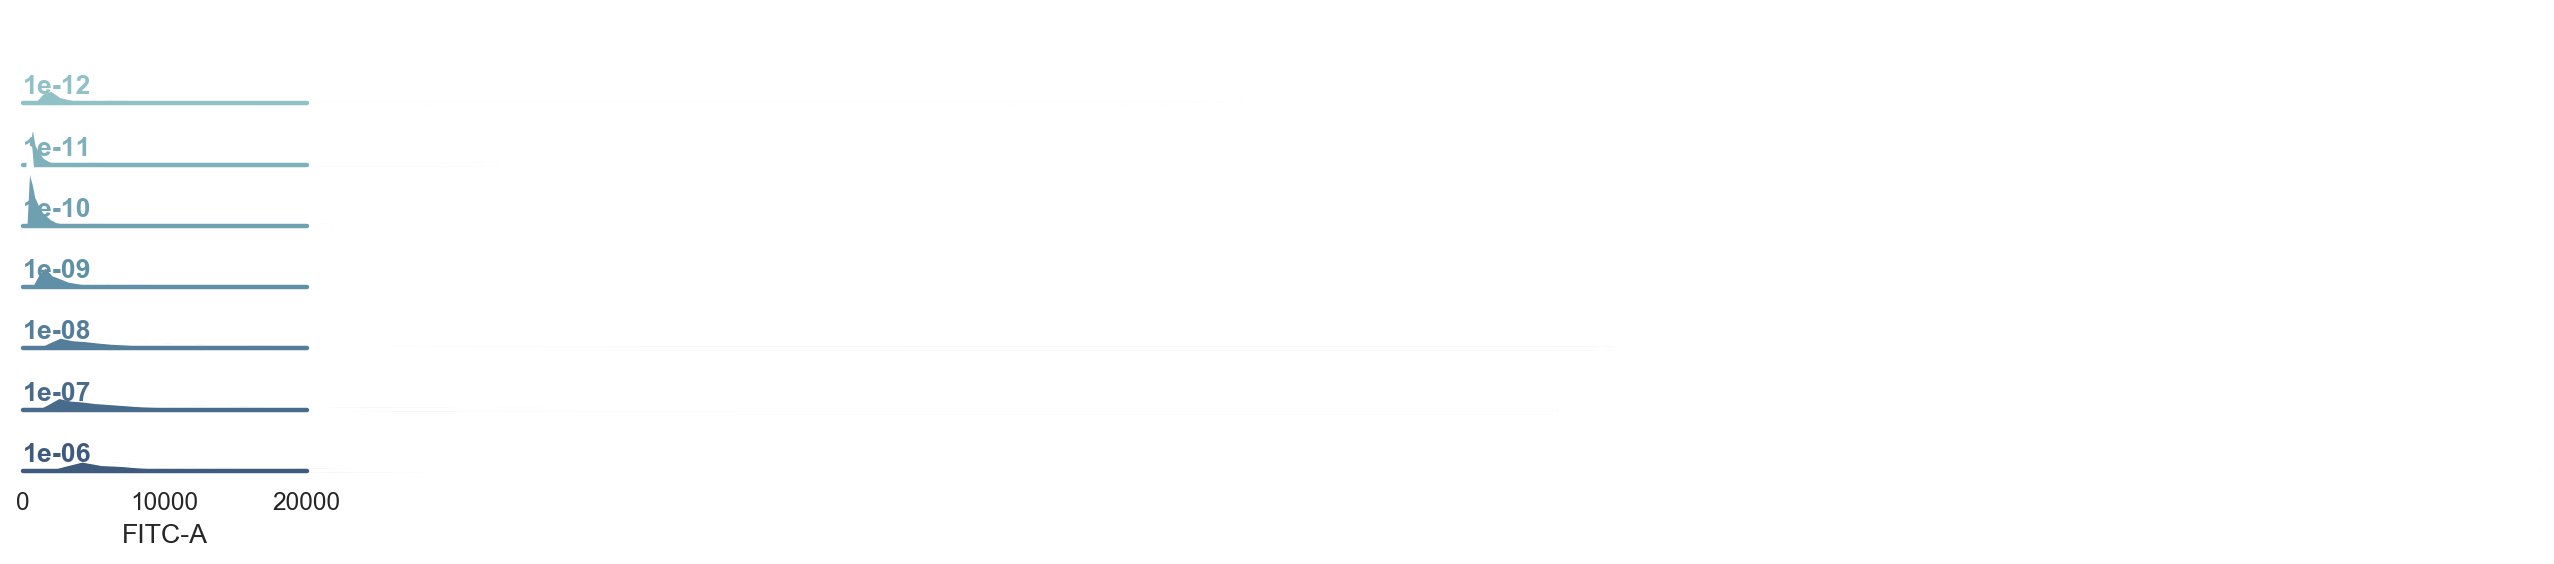

In [39]:
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
#rs = np.random.RandomState(1979)
#x = rs.randn(500)
#g = np.tile(list("ABCDEFGHIJ"), 50)
#df = pd.DataFrame(dict(x=x, g=g))
#m = df.g.map(ord)
#df["x"] += m
tmpdf = df[df.IPTG==0][['AHL','FITC-A']]
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(tmpdf, row="AHL", hue="AHL", aspect=5, height=0.5, palette=pal)
g.set(xlim=(0, 20000))
# Draw the densities in a few steps
g.map(sns.kdeplot, "FITC-A", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "FITC-A", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "FITC-A")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

